In [18]:
import numpy as np
import matplotlib.pyplot as plt

# fix random seed
np.random.seed(123)

# set the size of the model N x N and initial spins
N = 25
spins_initial = np.random.choice([-1,1], (N,N))
print(spins_initial.sum())
print(spins_initial.shape)

# fix time-steps
time_steps = 2000

31
(25, 25)


In [19]:
# Initialize interaction arrays: there are four arrays - up, down, left, right neighbours of a site
up, down, left, right = np.zeros((N, N)), np.zeros((N, N)), np.zeros((N, N)), np.zeros((N, N))

# Use J = 1 so graphs are easier to generate
up[1:N, :] = 1
down[0:N-1, :] = up[1:N, :]
left[:, 1:N] = 1
right[:, 0:N-1] = left[:, 1:N]

In [20]:
# create function to find neighbor sites
def nbr_udlr(s_site, s_array):
    n = s_array.shape[0]
    i = s_site[0]
    j = s_site[1]
    
    if i == 0:
        up_site = 0
        down_site = [i+1,j]
    elif i == n-1:
        up_site = [i-1, j]
        down_site = 0
    else: 
        up_site = [i-1, j]
        down_site = [i+1, j]
    
    if j == 0:
        left_site = 0
        right_site = [i, j+1]
    elif j == n-1:
        left_site = [i, j-1]
        right_site = 0
    else:
        left_site = [i, j-1]
        right_site = [i, j+1]
        
    return [up_site, down_site, left_site, right_site]

# create function to return interaction strength
def  int_strength(s_site, udlr, up_array, down_array, left_array, right_array):
    if udlr == 0:
        return up_array[s_site[0], s_site[1]]
    if udlr == 1:
        return down_array[s_site[0], s_site[1]]
    if udlr == 2:
        return left_array[s_site[0], s_site[1]]
    if udlr == 3:
        return right_array[s_site[0], s_site[1]]

def energy_calc(s_array, up_array, down_array, left_array, right_array):
    _N = s_array.shape[0]
    energy = 0

    # find all the values of the neighbors
    for i in range(_N):
        for j in range(_N):
            if i == 0:
                up_nbr = 0
                down_nbr = s_array[i+1,j]
            elif i == N-1:
                up_nbr = s_array[i-1,j]
                down_nbr = 0
            else:
                up_nbr = s_array[i-1,j]
                down_nbr = s_array[i+1,j]
            if j == 0:
                left_nbr = 0
                right_nbr = s_array[i,j+1]
            elif j == N-1:
                left_nbr = s_array[i,j-1]
                right_nbr = 0
            else:
                left_nbr = s_array[i,j-1]
                right_nbr = s_array[i,j+1]
        
            energy += s_array[i,j]*(up_array[i,j]*up_nbr + down_array[i,j]*down_nbr + left_array[i,j]*left_nbr + right_array[i,j]*right_nbr)
    return -energy/2 # each site is calculated twice

In [21]:
Energy_LSS = np.zeros(time_steps)
def latent_slice_sampler(bt, ts, s_array, up_array, down_array, left_array, right_array):
  
  lv = np.zeros(N**2) # latent variable
  sv = lv.copy() # latent variable
  left = lv.copy()
  right = lv.copy()

  z_value = np.random.choice([-1,1], N**2)
  z_new = z_value.copy()
  z_binary = z_value.copy()

  for i in range(ts):
    spin_tmp = s_array.copy()
    # calculate likelihood
    w = np.log(np.random.rand()) - bt * energy_calc(spin_tmp, up_array, down_array, left_array, right_array)
    lv = z_value - sv/2 + np.random.rand(N**2) * sv
    sv = 2 * abs(lv-z_value) + 10 * np.random.exponential(1, N**2)
    left = np.maximum(-2, lv - sv/2)
    right = np.minimum(2, lv + sv/2)
    
    tmp = 0
    while tmp == 0:
      z_new = left + np.random.rand(N**2) * (right-left)
      z_binary = np.array([1 if z_new[i] > 0 else -1 for i in range(N**2)])
      spin_tmp = np.reshape(z_binary, (N, N))

      w_tmp = - bt * energy_calc(spin_tmp, up_array, down_array, left_array, right_array)
      if w_tmp > w:
        z_value = z_new
        s_array = spin_tmp.copy()
        Energy_LSS[i] = energy_calc(s_array, up_array, down_array, left_array, right_array)
        tmp = 1
      else:
        r = np.array([1 if z_new[i] < z_value[i] else 0 for i in range(N**2)])
        left = r * np.maximum(left, z_new) + (1 - r) * left
        right = (1 - r) * np.minimum(right, z_new) + r * right   
    if i % 100 == 0:
      print(i)

In [22]:
beta = 1
spins = spins_initial.copy()
latent_slice_sampler(beta, time_steps, spins, up, down, left, right)
print(Energy_LSS.min())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
-526.0


In [23]:
energy_calc(np.ones((N, N)), up, down, left, right)

-1200.0

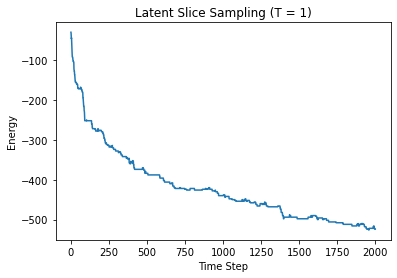

In [24]:
plt.plot(Energy_LSS)
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.title('Latent Slice Sampling (T = 1)')
plt.show()

In [15]:
beta = 1/5
spins = spins_initial.copy()
latent_slice_sampler(beta, time_steps, spins, up, down, left, right)
print(Energy_LSS.min())

0
100
200
300
400
500
600
700
800
900
-348.0


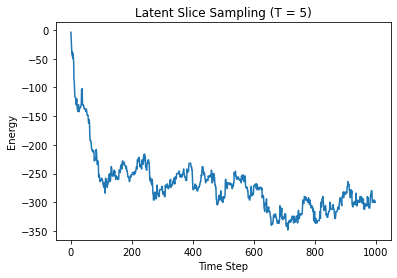

In [16]:
plt.plot(Energy_LSS)
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.title('Latent Slice Sampling (T = 5)')
plt.show()